### Import required libraries

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt

### Defining a Breakout Wide Receivers in Fantasy Football (NFL)
The goal of this notebook is to identify potential breakout (BO) wide recievers (WR) for the upcoming 2022-2023 NFL fantasy football season. Finding players with such upside in later rounds of a fantasy draft are one of the many possible ways to building a successful fantasy roster.
For the purposes of this study, the term breakout WR wil be defined as any WR with an Average Draft Position (ADP) of rounds 6-9 (12 team league, pick #: 60-108) who outscore their projected fantasy points per game by 'X' amount of points. 
The model used to predict fantasy points will be generated from the 2013-2021 seasons by creating a linear regression model for fantasy points per game as a function of ADP. Such model will then be applied to 2022 ADP data to predict potential BO WRs for this coming season.

### Scrape and Clean/Export PPR ADP for 2013 - 2021

In [113]:
pd.set_option('display.max_columns', None)

def name_splitter(objstr):
    """
    Inputs:
        objstr - obj input of scraped df.Player column
    Output:
        Returns a string output in the format of "First_name Last_name"
    """
    str1 = re.split(r",", re.sub(r"\b[A-Z]{2,3}\s[A-Z]{2}\b",'',objstr))
    f_output = str1[1].lstrip() + str1[0]
    return f_output

URL = 'https://www77.myfantasyleague.com/{year}/reports?R=ADP&POS=*&PERIOD=ALL&CUTOFF=5&FCOUNT=12&ROOKIES=0&INJURED=0&IS_PPR=2&IS_KEEPER=N&IS_MOCK=1&PAGE=ALL'

s_path = 'data/ADP/{year}_ppr_adp.csv'

# scrapes and does simply cleaning of adp data and exports as csv to be loaded and compiled later
for year in range(2013,2022):
    res = requests.get(URL.format(year=year))
    soup = bs(res.content, 'html5lib')
    table = soup.find('table', {'class':'report'})
    df = pd.read_html(str(table))[0]
    df = df.iloc[:-1,:]
    df['Pos'] = df['Player'].apply(lambda x: x.split()[-1])
    df['Tm'] = df['Player'].apply(lambda x: x.split()[-2])
    df['Player'] = np.where(df['Pos'] != 'Def', df['Player'].apply(name_splitter), df['Player'])
    df['Season'] = year
    df = df.drop(columns=[
        'Min Pick',
        'Max Pick',
        '% Selected'
    ])
    df.to_csv(s_path.format(year=year),index=False)

### Import Data

In [5]:
# scraped and compiled previously from Pro Football Reference (URL: 'https://www.pro-football-reference.com/years/{year}/fantasy.htm')

master_df = pd.read_csv('data/Yearly/yearly_compiled_2013_2021.csv') 
master_df = master_df.drop(columns = {'FantasyPoints','Unnamed: 0'})

master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5598 entries, 0 to 5597
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Season        5598 non-null   int64  
 1   Player        5598 non-null   object 
 2   Tm            5598 non-null   object 
 3   Pos           5475 non-null   object 
 4   Age           5598 non-null   float64
 5   G             5598 non-null   float64
 6   GS            5598 non-null   float64
 7   Tgt           5597 non-null   float64
 8   Rec           5597 non-null   float64
 9   PassingYds    5597 non-null   float64
 10  PassingTD     5597 non-null   float64
 11  PassingAtt    5597 non-null   float64
 12  RushingYds    5597 non-null   float64
 13  RushingTD     5597 non-null   float64
 14  RushingAtt    5597 non-null   float64
 15  ReceivingYds  5597 non-null   float64
 16  ReceivingTD   5597 non-null   float64
 17  Int           5597 non-null   float64
 18  Fumbles       5597 non-null 

In [6]:
# calculating total PPR fantasy points for each row (eg player X in season YYYY) based on that respective season's player stat line.
master_df['PPR'] = (master_df['RushingYds'] + master_df['ReceivingYds'])*0.1 + master_df['PassingYds']*0.04 + (master_df['RushingTD'] + master_df['ReceivingTD'])*6 \
    + master_df['PassingTD']*4 + master_df['Rec'] + master_df['FumblesLost']*-2 + master_df['Int']*-2 

master_df

,Season,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,PassingAtt,RushingYds,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,Int,Fumbles,FumblesLost,PPR
0,2013,Jamaal Charles,KAN,RB,27.0,15.0,15.0,104.0,70.0,0.0,...,0.0,1287.0,12.0,259.0,693.0,7.0,0.0,4.0,2.0,378.00
1,2013,Peyton Manning,DEN,QB,37.0,16.0,16.0,0.0,0.0,5477.0,...,659.0,-31.0,1.0,32.0,0.0,0.0,10.0,11.0,6.0,409.98
2,2013,LeSean McCoy,PHI,RB,25.0,16.0,16.0,64.0,52.0,0.0,...,0.0,1607.0,9.0,314.0,539.0,2.0,0.0,1.0,1.0,330.60
3,2013,Matt Forte,CHI,RB,28.0,16.0,16.0,95.0,74.0,0.0,...,0.0,1339.0,9.0,289.0,594.0,3.0,0.0,2.0,2.0,335.30
4,2013,Marshawn Lynch,SEA,RB,27.0,16.0,16.0,44.0,36.0,0.0,...,0.0,1257.0,12.0,301.0,316.0,2.0,0.0,4.0,1.0,275.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5593,2021,Travis Benjamin,SFO,NaN,32.0,10.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.00
5594,2021,Trenton Cannon,2TM,RB,27.0,12.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,-1.60
5595,2021,John Wolford,LAR,QB,26.0,3.0,0.0,0.0,0.0,5.0,...,4.0,-1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,-1.90
5596,2021,Josh Rosen,ATL,QB,24.0,4.0,0.0,0.0,0.0,19.0,...,11.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,-3.24


In [7]:
# import and compile previously scraped ADP data into one dataframe
adp_path = 'data/ADP/{year}_ppr_adp.csv'
adp_df = pd.DataFrame()

for year in range(2013,2022):
    y_df = pd.read_csv(adp_path.format(year=year))
    adp_df = pd.concat([adp_df,y_df])

print(adp_df.shape)

(3055, 6)


In [8]:
# rename values of adp_df.Tm to match with Tm values in the master_df
adp_df.replace({'Tm':{
    'GBP':'GNB',
    'JAC':'JAX',
    'KCC':'KAN',
    'NEP':'NWE',
    'NOS':'NOR',
    'OAK':'LVR',
    'SDC':'LAC',
    'STL':'LAR',
    'TBB':'TAM'
}}, inplace=True)

# the default output of Pandas replace method return a new dataframe (default: inplace = False). 
# by setting (inplace = True), though the method will return nothing, it will instead directly modify the dataframe being operated on.

In [9]:
# rename values of master_df.Tm to account for franchise city changes
master_df.replace({'Tm':{
    'OAK':'LVR',
    'SDG':'LAC',
    'STL':'LAR'
}}, inplace=True)

### Merge DataFrames

In [10]:
# merged dataframes by Player, Season, Tm, and Pos via an inner join
analysis_df = master_df.merge(adp_df, how='inner', on=['Player','Season','Tm','Pos'])

analysis_df

,Season,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,Int,Fumbles,FumblesLost,PPR,Rank,Avg Pick
0,2013,Jamaal Charles,KAN,RB,27.0,15.0,15.0,104.0,70.0,0.0,...,12.0,259.0,693.0,7.0,0.0,4.0,2.0,378.00,4,5.56
1,2013,Peyton Manning,DEN,QB,37.0,16.0,16.0,0.0,0.0,5477.0,...,1.0,32.0,0.0,0.0,10.0,11.0,6.0,409.98,34,36.77
2,2013,LeSean McCoy,PHI,RB,25.0,16.0,16.0,64.0,52.0,0.0,...,9.0,314.0,539.0,2.0,0.0,1.0,1.0,330.60,9,8.58
3,2013,Matt Forte,CHI,RB,28.0,16.0,16.0,95.0,74.0,0.0,...,9.0,289.0,594.0,3.0,0.0,2.0,2.0,335.30,12,14.41
4,2013,Marshawn Lynch,SEA,RB,27.0,16.0,16.0,44.0,36.0,0.0,...,12.0,301.0,316.0,2.0,0.0,4.0,1.0,275.30,10,10.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2209,2021,Tylan Wallace,BAL,WR,22.0,17.0,1.0,6.0,2.0,0.0,...,0.0,0.0,23.0,0.0,0.0,0.0,0.0,4.30,339,236.10
2210,2021,Keke Coutee,IND,WR,24.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.50,322,222.92
2211,2021,Ryan Fitzpatrick,WAS,QB,39.0,1.0,1.0,0.0,0.0,13.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.72,185,148.65
2212,2021,Hunter Long,MIA,TE,23.0,7.0,2.0,3.0,1.0,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.80,335,231.93


In [11]:

# check for missing values in all columns
analysis_df.isna().sum()

Season          0
Player          0
Tm              0
Pos             0
Age             0
G               0
GS              0
Tgt             0
Rec             0
PassingYds      0
PassingTD       0
PassingAtt      0
RushingYds      0
RushingTD       0
RushingAtt      0
ReceivingYds    0
ReceivingTD     0
Int             0
Fumbles         0
FumblesLost     0
PPR             0
Rank            0
Avg Pick        0
dtype: int64

### Export Merged DataFrame

In [12]:
analysis_df.to_csv('data/Analysis/analysis_yearly_2013_2021_ppr_adp.csv', index=False)

### Further Data Cleaning and Feature Engineering

In [13]:
# isolate analysis_df for WR only as we are trying to find characteristics of potential breakout WRs (WR who outperform their ADP)
analysis_df = analysis_df.loc[analysis_df.Pos == 'WR', :]

analysis_df

,Season,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,RushingTD,RushingAtt,ReceivingYds,ReceivingTD,Int,Fumbles,FumblesLost,PPR,Rank,Avg Pick
6,2013,Demaryius Thomas,DEN,WR,26.0,16.0,16.0,142.0,92.0,0.0,...,0.0,0.0,1430.0,14.0,0.0,2.0,0.0,319.0,20,21.88
7,2013,Josh Gordon,CLE,WR,22.0,14.0,14.0,159.0,87.0,0.0,...,0.0,5.0,1646.0,9.0,0.0,0.0,0.0,314.4,83,86.00
8,2013,Calvin Johnson,DET,WR,28.0,14.0,14.0,156.0,84.0,0.0,...,0.0,0.0,1492.0,12.0,0.0,1.0,1.0,303.2,5,5.91
10,2013,A.J. Green,CIN,WR,25.0,16.0,16.0,178.0,98.0,0.0,...,0.0,0.0,1426.0,11.0,0.0,1.0,0.0,306.6,11,14.00
11,2013,Brandon Marshall,CHI,WR,29.0,16.0,16.0,164.0,100.0,0.0,...,0.0,0.0,1295.0,12.0,0.0,0.0,0.0,301.5,15,17.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2021,Amari Rodgers,GNB,WR,22.0,16.0,1.0,8.0,4.0,0.0,...,0.0,1.0,45.0,0.0,0.0,2.0,0.0,9.6,295,206.98
2204,2021,Will Fuller,MIA,WR,27.0,2.0,0.0,8.0,4.0,0.0,...,0.0,0.0,26.0,0.0,0.0,0.0,0.0,6.6,128,122.50
2205,2021,Curtis Samuel,WAS,WR,25.0,5.0,1.0,9.0,6.0,0.0,...,0.0,4.0,27.0,0.0,0.0,0.0,0.0,9.8,131,123.17
2209,2021,Tylan Wallace,BAL,WR,22.0,17.0,1.0,6.0,2.0,0.0,...,0.0,0.0,23.0,0.0,0.0,0.0,0.0,4.3,339,236.10


In [14]:
# load previously scraped NFL Draft data for all WR 
wr_draft_df = pd.read_csv('data/Draft/wr_draft_pick_2022.csv')

wr_draft_df = wr_draft_df.drop(columns=['round','pick','Pos'])
wr_draft_df

,rookie_s,Player
0,2022.0,Drake London
1,2022.0,Garrett Wilson
2,2022.0,Chris Olave
3,2022.0,Jameson Williams
4,2022.0,Jahan Dotson
...,...,...
2249,1954.0,Raymond Berry
2250,1947.0,Dante Lavelli
2251,1945.0,Elroy Hirsch
2252,1945.0,Pete Pihos


In [15]:
# merging analysis dataframe with draft dataframe 
wr_analysis_df = analysis_df.merge(wr_draft_df, how='left', on=['Player'])
wr_analysis_df = wr_analysis_df.loc[wr_analysis_df.rookie_s > 1999, :]

In [16]:
# new column indicating how many years a player has played so far in a league (thus a current_yr of 1 indicates that the player is a rookie)
wr_analysis_df.loc[:,'current_yr'] = wr_analysis_df.Season - wr_analysis_df.rookie_s + 1.0
wr_analysis_df

,Season,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,ReceivingYds,ReceivingTD,Int,Fumbles,FumblesLost,PPR,Rank,Avg Pick,rookie_s,current_yr
0,2013,Demaryius Thomas,DEN,WR,26.0,16.0,16.0,142.0,92.0,0.0,...,1430.0,14.0,0.0,2.0,0.0,319.0,20,21.88,2010.0,4.0
1,2013,Josh Gordon,CLE,WR,22.0,14.0,14.0,159.0,87.0,0.0,...,1646.0,9.0,0.0,0.0,0.0,314.4,83,86.00,2013.0,1.0
2,2013,Calvin Johnson,DET,WR,28.0,14.0,14.0,156.0,84.0,0.0,...,1492.0,12.0,0.0,1.0,1.0,303.2,5,5.91,2007.0,7.0
3,2013,A.J. Green,CIN,WR,25.0,16.0,16.0,178.0,98.0,0.0,...,1426.0,11.0,0.0,1.0,0.0,306.6,11,14.00,2011.0,3.0
4,2013,Brandon Marshall,CHI,WR,29.0,16.0,16.0,164.0,100.0,0.0,...,1295.0,12.0,0.0,0.0,0.0,301.5,15,17.46,2006.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,2021,Amari Rodgers,GNB,WR,22.0,16.0,1.0,8.0,4.0,0.0,...,45.0,0.0,0.0,2.0,0.0,9.6,295,206.98,2021.0,1.0
904,2021,Will Fuller,MIA,WR,27.0,2.0,0.0,8.0,4.0,0.0,...,26.0,0.0,0.0,0.0,0.0,6.6,128,122.50,2016.0,6.0
905,2021,Curtis Samuel,WAS,WR,25.0,5.0,1.0,9.0,6.0,0.0,...,27.0,0.0,0.0,0.0,0.0,9.8,131,123.17,2017.0,5.0
906,2021,Tylan Wallace,BAL,WR,22.0,17.0,1.0,6.0,2.0,0.0,...,23.0,0.0,0.0,0.0,0.0,4.3,339,236.10,2021.0,1.0


In [17]:
# look at games played counts to determine minimum cut off to be included in the sample size
wr_analysis_df.G.value_counts(normalize=True)

16.0    0.412869
15.0    0.138070
14.0    0.092493
12.0    0.058981
13.0    0.053619
10.0    0.048257
11.0    0.040214
9.0     0.029491
17.0    0.029491
7.0     0.022788
6.0     0.020107
8.0     0.017426
5.0     0.014745
2.0     0.009383
3.0     0.005362
4.0     0.004021
1.0     0.002681
Name: G, dtype: float64

In [19]:
# roughly 8-9% of WR have played less than 9 games in any given season from 2013 to 2021
# such players will be removed from the sample to get a more accurate representation of fantasy points per game
wr_analysis_df = wr_analysis_df.loc[wr_analysis_df.G > 8, :]
wr_analysis_df.loc[:,'FPPG'] = wr_analysis_df['PPR'] / wr_analysis_df['G'] # this line may have to be run separately from the line above as a copywithsetting war#ning emerges; works despite the message

wr_analysis_df.shape

(674, 26)

In [20]:
# check for any NaN values before analysis
wr_analysis_df.isna().sum()

Season          0
Player          0
Tm              0
Pos             0
Age             0
G               0
GS              0
Tgt             0
Rec             0
PassingYds      0
PassingTD       0
PassingAtt      0
RushingYds      0
RushingTD       0
RushingAtt      0
ReceivingYds    0
ReceivingTD     0
Int             0
Fumbles         0
FumblesLost     0
PPR             0
Rank            0
Avg Pick        0
rookie_s        0
current_yr      0
FPPG            0
dtype: int64

In [21]:
# removed indexes of those that did not merge properly; looked at dataframe for inaccurate data
wr_analysis_df = wr_analysis_df.drop([wr_analysis_df.index[609], wr_analysis_df.index[549], wr_analysis_df.index[469], wr_analysis_df.index[381],wr_analysis_df.index[359],\
    wr_analysis_df.index[608],wr_analysis_df.index[548],wr_analysis_df.index[468],wr_analysis_df.index[380],wr_analysis_df.index[358]])

### Exploratory Data Analysis

Text(23.92500000000001, 0.5, 'FPPG')

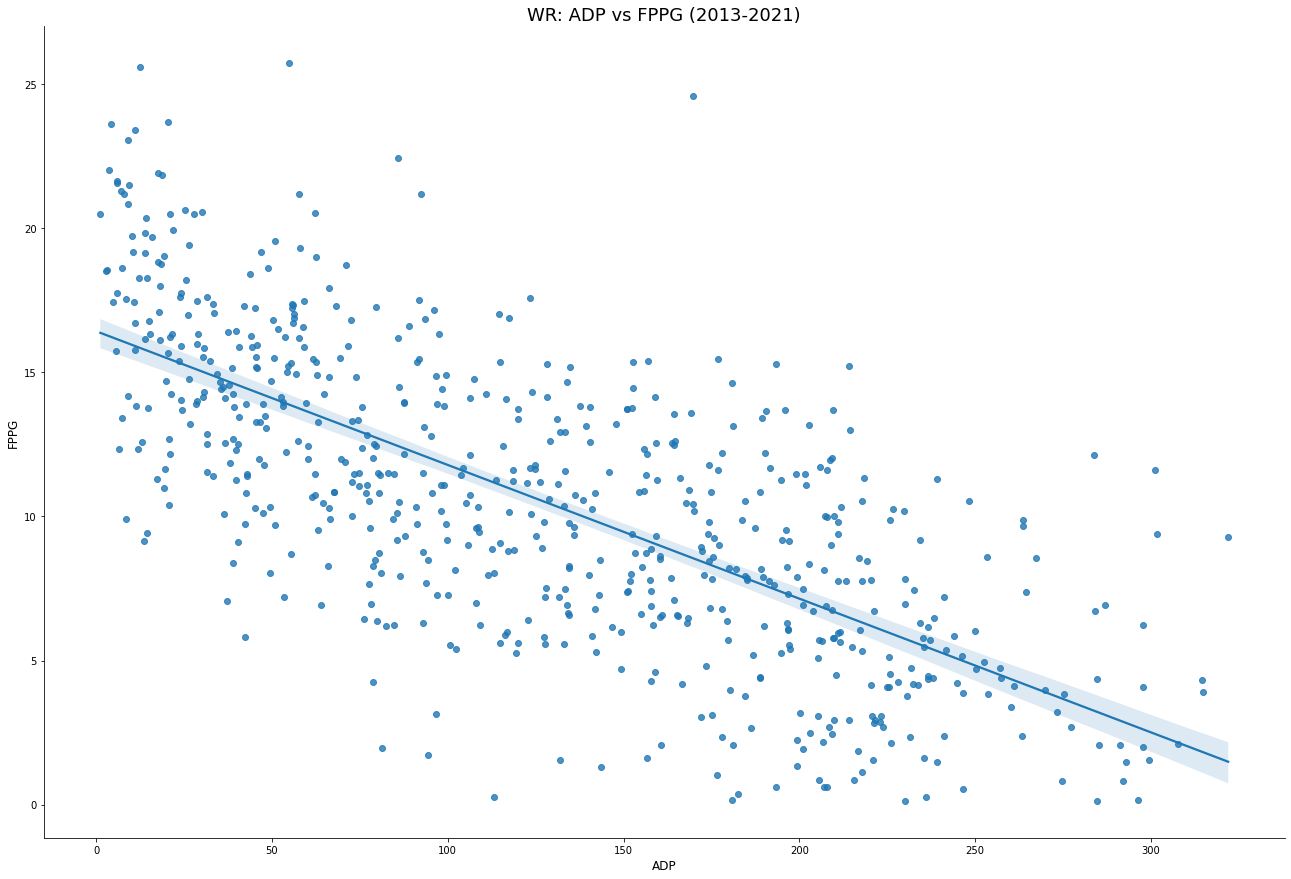

In [75]:
# plt.scatter(wr_analysis_df['Avg Pick'],wr_analysis_df['FPPG'])
sns.lmplot(x='Avg Pick', y='FPPG', data=wr_analysis_df, height = 12, aspect = 1.5)
plt.title('WR: ADP vs FPPG (2013-2021)', size=18)
plt.xlabel('ADP', size = 12)
plt.ylabel('FPPG', size = 12)

In [28]:
# preprocessing for linear regression model 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# preparing X and y for linear regression
X = wr_analysis_df['Avg Pick'].values.reshape(-1,1)
y = wr_analysis_df['FPPG'].values.reshape(-1,1)

SEED = 42 # random_state is set to seed to have reproducible results
# divide both our independent and dependent variable into training and test cases
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = .2, random_state=SEED)

In [29]:
model = LinearRegression()
model.fit(X_train,y_train) # trains the linear regression model on the training data

model_slope = model.coef_.squeeze()
model_intercept = model.intercept_.squeeze()

print(f'y = {model_slope:.4f}x + {model_intercept:.4f}')


y = -0.0450x + 16.2270


In [30]:
# comparing model to actual/real data
y_pred = model.predict(X_test)

df_pred = pd.DataFrame({'Actual':y_test.squeeze(), 'Predicted':y_pred.squeeze()})
df_pred



,Actual,Predicted
0,5.391667,11.618773
1,3.090000,6.997973
2,10.180000,11.813948
3,16.987500,15.047834
4,18.273333,15.674734
...,...,...
128,9.407143,8.397929
129,12.530667,12.672001
130,15.892500,14.233854
131,10.293333,13.243136


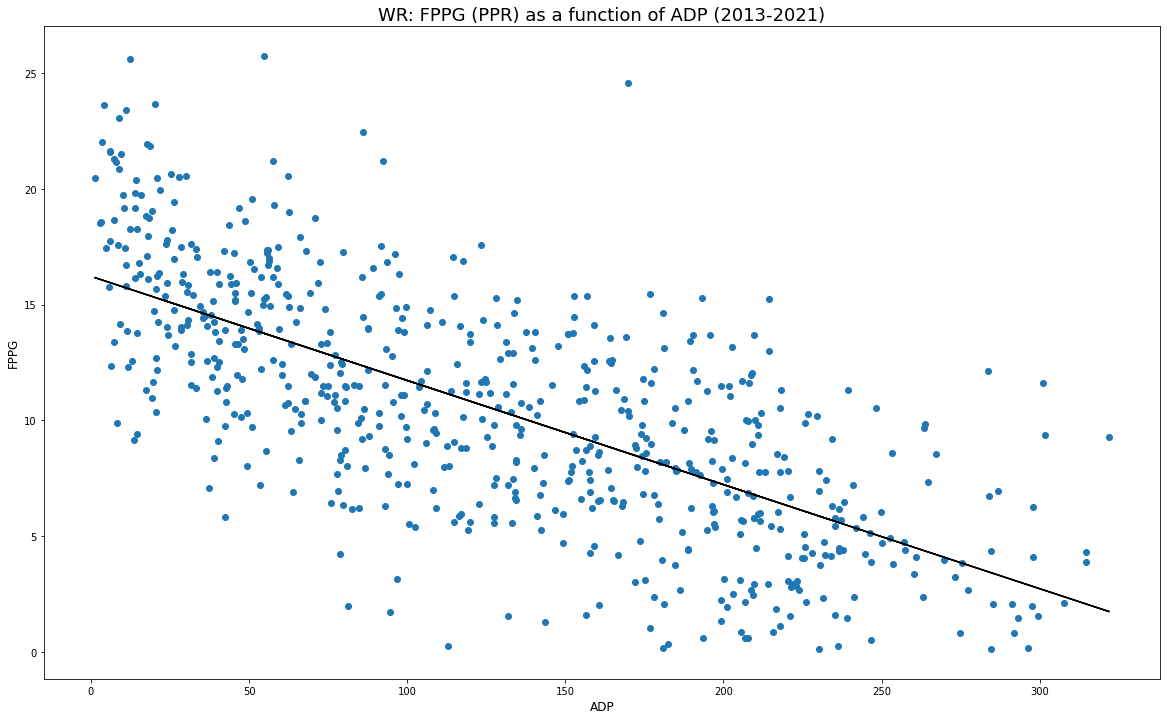

y = -0.0450x + 16.2270


In [32]:
plt.figure(figsize=(20,12))
plt.scatter(X,y)
plt.plot(X, model.predict(X), color='k')
plt.title('WR: FPPG (PPR) as a function of ADP (2013-2021)', size=18)
plt.xlabel('ADP', size = 12)
plt.ylabel('FPPG', size = 12)
plt.show()

print(f'y = {model_slope:.4f}x + {model_intercept:.4f}')

In [37]:
# evaluating the model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_pred) # gives idea of overall error for each predicition of the model, closer to 0/smaller, the better
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)

text = 'Evaluation Metrics '
print("\u0332".join(text))
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'R Squared (R2): {r2:.2f}')

E̲v̲a̲l̲u̲a̲t̲i̲o̲n̲ ̲M̲e̲t̲r̲i̲c̲s̲ 
Mean absolute error: 2.97
Mean squared error: 12.97
Root mean squared error: 3.60
R Squared (R2): 0.57


In [38]:
# creating a function to calculate the predicted (model) fppg to ultimately insert into df
def fp_pred(slope,intercept,pick):
    """
    Inputs:
        slope - linearregression.coef_
        intercept - linearregression.intercept_
        pick - average draft pick position
    Output:
        string output of predicted fantasy points per game for a given season
    """
    return slope*pick+intercept

In [39]:
# applying above function to to column to create a new column
wr_analysis_df.loc[:,'pred_fppg'] = wr_analysis_df['Avg Pick'].apply(lambda j: fp_pred(model_slope,model_intercept,j))

wr_analysis_df


,Season,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,Int,Fumbles,FumblesLost,PPR,Rank,Avg Pick,rookie_s,current_yr,FPPG,pred_fppg
0,2013,Demaryius Thomas,DEN,WR,26.0,16.0,16.0,142.0,92.0,0.0,...,0.0,2.0,0.0,319.0,20,21.88,2010.0,4.0,19.937500,15.243009
1,2013,Josh Gordon,CLE,WR,22.0,14.0,14.0,159.0,87.0,0.0,...,0.0,0.0,0.0,314.4,83,86.00,2013.0,1.0,22.457143,12.359450
2,2013,Calvin Johnson,DET,WR,28.0,14.0,14.0,156.0,84.0,0.0,...,0.0,1.0,1.0,303.2,5,5.91,2007.0,7.0,21.657143,15.961201
3,2013,A.J. Green,CIN,WR,25.0,16.0,16.0,178.0,98.0,0.0,...,0.0,1.0,0.0,306.6,11,14.00,2011.0,3.0,19.162500,15.597383
4,2013,Brandon Marshall,CHI,WR,29.0,16.0,16.0,164.0,100.0,0.0,...,0.0,0.0,0.0,301.5,15,17.46,2006.0,8.0,18.843750,15.441782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,2021,Dyami Brown,WAS,WR,22.0,15.0,6.0,25.0,12.0,0.0,...,0.0,0.0,0.0,28.1,312,216.63,2021.0,1.0,1.873333,6.484850
899,2021,N'Keal Harry,NWE,WR,24.0,12.0,4.0,22.0,12.0,0.0,...,0.0,1.0,1.0,28.4,370,263.24,2019.0,3.0,2.366667,4.388738
901,2021,Denzel Mims,NYJ,WR,24.0,11.0,3.0,23.0,8.0,0.0,...,0.0,0.0,0.0,21.3,285,200.99,2020.0,2.0,1.936364,7.188201
903,2021,Amari Rodgers,GNB,WR,22.0,16.0,1.0,8.0,4.0,0.0,...,0.0,2.0,0.0,9.6,295,206.98,2021.0,1.0,0.600000,6.918823


In [42]:
# creating a new column to observe the difference in fantasy points between actual and predicted
wr_analysis_df.loc[:,'diff_fppg'] = wr_analysis_df['FPPG'] - wr_analysis_df['pred_fppg']

wr_analysis_df

,Season,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,Fumbles,FumblesLost,PPR,Rank,Avg Pick,rookie_s,current_yr,FPPG,pred_fppg,diff_fppg
0,2013,Demaryius Thomas,DEN,WR,26.0,16.0,16.0,142.0,92.0,0.0,...,2.0,0.0,319.0,20,21.88,2010.0,4.0,19.937500,15.243009,4.694491
1,2013,Josh Gordon,CLE,WR,22.0,14.0,14.0,159.0,87.0,0.0,...,0.0,0.0,314.4,83,86.00,2013.0,1.0,22.457143,12.359450,10.097693
2,2013,Calvin Johnson,DET,WR,28.0,14.0,14.0,156.0,84.0,0.0,...,1.0,1.0,303.2,5,5.91,2007.0,7.0,21.657143,15.961201,5.695942
3,2013,A.J. Green,CIN,WR,25.0,16.0,16.0,178.0,98.0,0.0,...,1.0,0.0,306.6,11,14.00,2011.0,3.0,19.162500,15.597383,3.565117
4,2013,Brandon Marshall,CHI,WR,29.0,16.0,16.0,164.0,100.0,0.0,...,0.0,0.0,301.5,15,17.46,2006.0,8.0,18.843750,15.441782,3.401968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,2021,Dyami Brown,WAS,WR,22.0,15.0,6.0,25.0,12.0,0.0,...,0.0,0.0,28.1,312,216.63,2021.0,1.0,1.873333,6.484850,-4.611517
899,2021,N'Keal Harry,NWE,WR,24.0,12.0,4.0,22.0,12.0,0.0,...,1.0,1.0,28.4,370,263.24,2019.0,3.0,2.366667,4.388738,-2.022072
901,2021,Denzel Mims,NYJ,WR,24.0,11.0,3.0,23.0,8.0,0.0,...,0.0,0.0,21.3,285,200.99,2020.0,2.0,1.936364,7.188201,-5.251838
903,2021,Amari Rodgers,GNB,WR,22.0,16.0,1.0,8.0,4.0,0.0,...,2.0,0.0,9.6,295,206.98,2021.0,1.0,0.600000,6.918823,-6.318823


In [64]:
# we filter out all players whose ADP did not fall between rounds 6 - 9 inclusive in a 12 team PPR fantasy league
bo_sample_wr_analysis_df = wr_analysis_df.loc[(wr_analysis_df.Rank >= 60) & (wr_analysis_df.Rank <= 108),:]

In [65]:
bo_sample_wr_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 1 to 884
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Season        124 non-null    int64  
 1   Player        124 non-null    object 
 2   Tm            124 non-null    object 
 3   Pos           124 non-null    object 
 4   Age           124 non-null    float64
 5   G             124 non-null    float64
 6   GS            124 non-null    float64
 7   Tgt           124 non-null    float64
 8   Rec           124 non-null    float64
 9   PassingYds    124 non-null    float64
 10  PassingTD     124 non-null    float64
 11  PassingAtt    124 non-null    float64
 12  RushingYds    124 non-null    float64
 13  RushingTD     124 non-null    float64
 14  RushingAtt    124 non-null    float64
 15  ReceivingYds  124 non-null    float64
 16  ReceivingTD   124 non-null    float64
 17  Int           124 non-null    float64
 18  Fumbles       124 non-null    

In [66]:
# breakout (bo) is defined arbitrarily as any player who outperforms his predicted fppg by at least 2.90 points
bo_wr_analysis_df = bo_sample_wr_analysis_df.loc[(bo_sample_wr_analysis_df.diff_fppg > 2.90), :]
bo_wr_analysis_df

,Season,Player,Tm,Pos,Age,G,GS,Tgt,Rec,PassingYds,...,Fumbles,FumblesLost,PPR,Rank,Avg Pick,rookie_s,current_yr,FPPG,pred_fppg,diff_fppg
1,2013,Josh Gordon,CLE,WR,22.0,14.0,14.0,159.0,87.0,0.0,...,0.0,0.0,314.40,83,86.00,2013.0,1.0,22.457143,12.359450,10.097693
9,2013,DeSean Jackson,PHI,WR,27.0,16.0,16.0,126.0,82.0,0.0,...,1.0,0.0,269.40,68,72.49,2008.0,6.0,16.837500,12.967012,3.870488
14,2013,Anquan Boldin,SFO,WR,33.0,16.0,16.0,129.0,85.0,0.0,...,0.0,0.0,246.00,85,91.21,2003.0,11.0,15.375000,12.125150,3.249850
104,2014,Emmanuel Sanders,DEN,WR,27.0,16.0,16.0,141.0,101.0,0.0,...,1.0,0.0,299.80,66,70.94,2010.0,5.0,18.737500,13.036718,5.700782
106,2014,Jeremy Maclin,PHI,WR,26.0,16.0,16.0,143.0,85.0,0.0,...,0.0,0.0,276.80,64,68.12,2009.0,6.0,17.300000,13.163537,4.136463
108,2014,Mike Evans,TAM,WR,21.0,15.0,15.0,122.0,68.0,0.0,...,0.0,0.0,245.10,91,97.52,2014.0,1.0,16.340000,11.841381,4.498619
110,2014,Golden Tate,DET,WR,26.0,16.0,16.0,144.0,99.0,0.0,...,1.0,0.0,259.10,79,85.86,2010.0,5.0,16.193750,12.365746,3.828004
208,2015,Eric Decker,NYJ,WR,28.0,15.0,13.0,132.0,80.0,0.0,...,1.0,1.0,252.70,85,93.57,2010.0,6.0,16.846667,12.019017,4.827649
209,2015,Larry Fitzgerald,ARI,WR,32.0,16.0,16.0,145.0,109.0,0.0,...,2.0,2.0,280.50,83,91.84,2004.0,12.0,17.531250,12.096818,5.434432
314,2016,Michael Thomas,NOR,WR,23.0,15.0,12.0,121.0,92.0,0.0,...,2.0,2.0,255.70,108,114.45,2016.0,1.0,17.046667,11.080017,5.966650


In [76]:
bo_2013_2021_count = bo_wr_analysis_df.current_yr.value_counts()


<AxesSubplot:title={'center':'Breakout WR Current Year Distribution (2013-2021)'}, xlabel='Years in League', ylabel='# of WRs'>

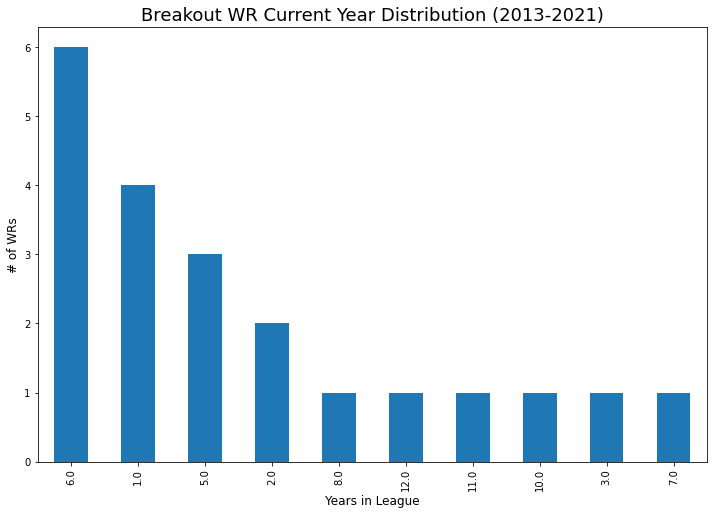

In [82]:
plt.figure(figsize=(12,8))
plt.title("Breakout WR Current Year Distribution (2013-2021)", size =18)
plt.xlabel("Years in League", size=12)
plt.ylabel("# of WRs",size=12)
bo_2013_2021_count.plot(kind='bar')

In [68]:
# wr drafted in rounds 6-12 of PPR fantasy in seasons of 2013-2021
r6_r12_wr_analysis_df = wr_analysis_df.loc[(wr_analysis_df.Rank >= 60) & (wr_analysis_df.Rank <= 108),:]

Text(0, 0.5, 'Diff. FPPG relative to ADP')

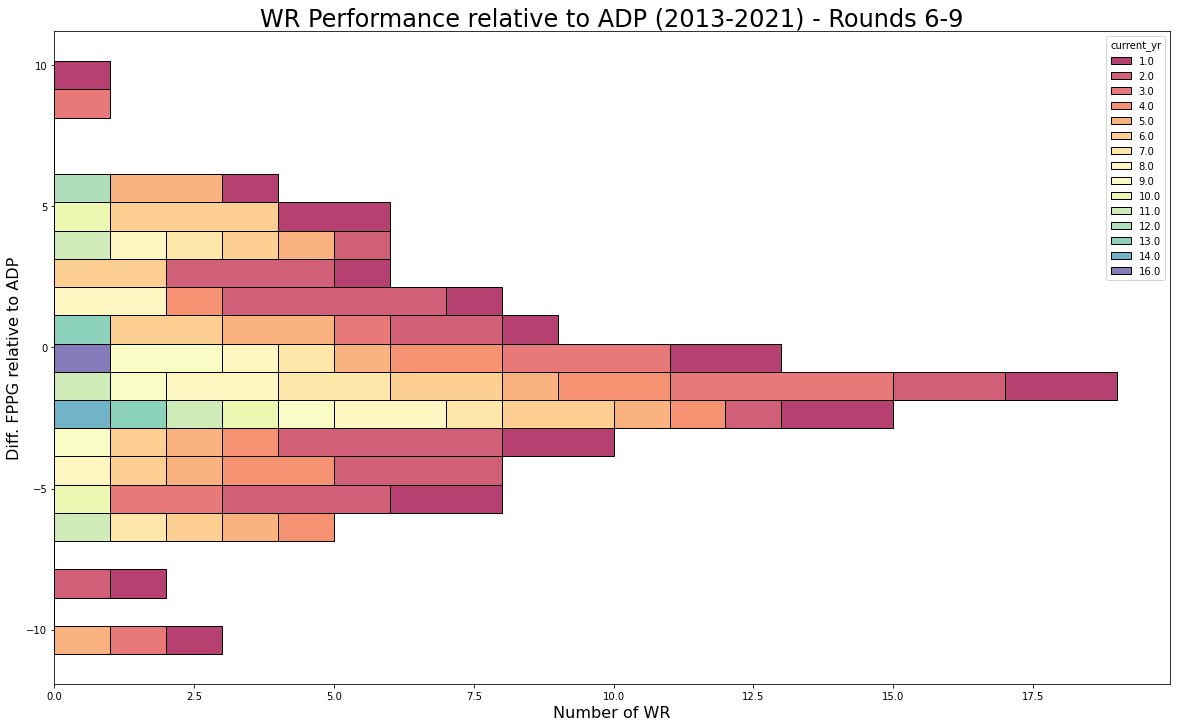

In [79]:
plt.figure(figsize=(20,12))
sns.histplot(data = r6_r12_wr_analysis_df, y='diff_fppg', hue='current_yr', multiple = 'stack',binwidth=1, palette='Spectral')
plt.title('WR Performance relative to ADP (2013-2021) - Rounds 6-9', size =24)
plt.xlabel('Number of WR', size=16)
plt.ylabel('Diff. FPPG relative to ADP', size=16)

In [60]:
adp_2022_df = pd.read_csv('data/ADP/ADP_PPR_rankings_fantasypros_07202022.csv')
adp_2022_df

,Rank,Player,Team,Bye,POS,ESPN,RTSports,MFL,Fantrax,FFC,Sleeper,AVG
0,1.0,Jonathan Taylor,IND,14.0,RB1,1.0,1.0,NaN,1.0,1.0,1.0,1.0
1,2.0,Christian McCaffrey,CAR,13.0,RB2,3.0,2.0,NaN,4.0,2.0,2.0,2.6
2,3.0,Austin Ekeler,LAC,8.0,RB3,4.0,3.0,NaN,2.0,3.0,4.0,3.2
3,4.0,Cooper Kupp,LAR,7.0,WR1,2.0,6.0,NaN,3.0,5.0,5.0,4.2
4,5.0,Derrick Henry,TEN,6.0,RB4,5.0,8.0,NaN,5.0,4.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
383,384.0,Derrick Gore,KC,8.0,RB107,NaN,NaN,NaN,376.0,NaN,NaN,376.0
384,385.0,Tommy Tremble,CAR,13.0,TE43,NaN,NaN,NaN,377.0,NaN,NaN,377.0
385,386.0,Daniel Bellinger,NYG,9.0,TE44,NaN,NaN,NaN,378.0,NaN,NaN,378.0
386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
adp_2022_df = adp_2022_df.drop(columns=['Bye','ESPN','RTSports','MFL','Fantrax','FFC','Sleeper'])
adp_2022_df.drop(adp_2022_df.tail(2).index, inplace=True)

# NaN values in Team column; upon closer inspection, such entries are of WR who are not currently signed to any team.
# Thus, we will keep them in our sample as the Team variable is not used for this study as a data point for analysis.
adp_2022_df.isna().sum()

Rank       0
Player     0
Team      16
POS        0
AVG        0
dtype: int64

In [62]:
# remove the integer from each entry in POS column
adp_2022_df['POS'] = adp_2022_df['POS'].str[:2]

In [63]:
# create the study population for potential breakout WR from 2022 ADP data
wr_bo_2022_df = adp_2022_df.loc[(adp_2022_df.Rank >= 60) & (adp_2022_df.Rank <= 108) & (adp_2022_df.POS == 'WR'),:]
wr_bo_2022_df

,Rank,Player,Team,POS,AVG
61,62.0,Darnell Mooney,CHI,WR,64.4
62,63.0,Jerry Jeudy,DEN,WR,65.2
64,65.0,Amon-Ra St. Brown,DET,WR,65.4
68,69.0,Allen Robinson II,LAR,WR,69.4
70,71.0,Michael Thomas,NO,WR,70.0
71,72.0,Adam Thielen,MIN,WR,70.4
72,73.0,Gabriel Davis,BUF,WR,74.4
77,78.0,Hunter Renfrow,LV,WR,77.6
79,80.0,DeAndre Hopkins,ARI,WR,80.6
80,81.0,JuJu Smith-Schuster,KC,WR,81.6


In [70]:
temp_wr_draft_df = wr_draft_df.loc[wr_draft_df.rookie_s > 2010]

wr_bo_2022_df = wr_bo_2022_df.merge(temp_wr_draft_df, how='left',on=['Player'])
wr_bo_2022_df

,Rank,Player,Team,POS,AVG,rookie_s
0,62.0,Darnell Mooney,CHI,WR,64.4,2020.0
1,63.0,Jerry Jeudy,DEN,WR,65.2,2020.0
2,65.0,Amon-Ra St. Brown,DET,WR,65.4,2021.0
3,69.0,Allen Robinson II,LAR,WR,69.4,NaN
4,71.0,Michael Thomas,NO,WR,70.0,2016.0
5,72.0,Adam Thielen,MIN,WR,70.4,NaN
6,73.0,Gabriel Davis,BUF,WR,74.4,2020.0
7,78.0,Hunter Renfrow,LV,WR,77.6,2019.0
8,80.0,DeAndre Hopkins,ARI,WR,80.6,2013.0
9,81.0,JuJu Smith-Schuster,KC,WR,81.6,2017.0


In [72]:
wr_bo_2022_df.isna().sum()

Rank        0
Player      0
Team        0
POS         0
AVG         0
rookie_s    2
dtype: int64

In [73]:
# fix NaN values for Adam Thielen and Allen Robinson II
wr_bo_2022_df.iloc[3,5] = float(2014) 
wr_bo_2022_df.iloc[5,5] = float(2014)

wr_bo_2022_df.loc[:,'current_yr'] = 2022 - wr_bo_2022_df.rookie_s + 1

wr_bo_2022_df

,Rank,Player,Team,POS,AVG,rookie_s,current_yr
0,62.0,Darnell Mooney,CHI,WR,64.4,2020.0,3.0
1,63.0,Jerry Jeudy,DEN,WR,65.2,2020.0,3.0
2,65.0,Amon-Ra St. Brown,DET,WR,65.4,2021.0,2.0
3,69.0,Allen Robinson II,LAR,WR,69.4,2014.0,9.0
4,71.0,Michael Thomas,NO,WR,70.0,2016.0,7.0
5,72.0,Adam Thielen,MIN,WR,70.4,2014.0,9.0
6,73.0,Gabriel Davis,BUF,WR,74.4,2020.0,3.0
7,78.0,Hunter Renfrow,LV,WR,77.6,2019.0,4.0
8,80.0,DeAndre Hopkins,ARI,WR,80.6,2013.0,10.0
9,81.0,JuJu Smith-Schuster,KC,WR,81.6,2017.0,6.0


In [74]:
# now we filter out rookie, year 5, and year 6 receivers as 13/21 (61.9%) of the BO WR from 2013-2021 have been such age
wr_bo_2022_df.loc[(wr_bo_2022_df.current_yr == 1)|(wr_bo_2022_df.current_yr == 5)|(wr_bo_2022_df.current_yr == 6),:]

,Rank,Player,Team,POS,AVG,rookie_s,current_yr
9,81.0,JuJu Smith-Schuster,KC,WR,81.6,2017.0,6.0
14,94.0,Drake London,ATL,WR,96.6,2022.0,1.0
17,101.0,Treylon Burks,TEN,WR,103.4,2022.0,1.0
18,103.0,Christian Kirk,JAC,WR,104.6,2018.0,5.0
19,104.0,Russell Gage,TB,WR,106.0,2018.0,5.0
